In [1]:
from SupertypeTools import CGCalcMat, heatmap, SSE, hierarchical_cluster, Silhouette
import pandas as pd
import matplotlib.pyplot as plt
# contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #MHCpan
# contactA = [5,7,9,24,25,34,45,59,63,66,67,70,74,77,80,81,84,97,99,113,114,116,123,133,143,146,147,152,155,156,159,160,163,167,171]
# contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

# weight = {3:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]}

#Hanneke W.M. van Deutekom and Can Kesmir 2015
contact = [7,9,24,45,59,63,66,67,69,70,74,76,77,80,95,97,99,114,116,152,156,158,163,167,171]
weight = {9.9:[63],7.6:[67],5.8:[116],5.4:[9],4.7:[97],4.6:[152],3.8:[167],3.7:[156],3.6:[74],3.2:[70],3:[80],2.9:[171],2.8:[45],2.7:[66],2.7:[77],2.4:[76],2.3:[114],2.1:[99],1.5:[163],1.5:[95],1.4:[59],1.4:[158],1.2:[69],1.2:[24],1:[7]}

## Tuning number of clusters

In [2]:
def Tuning_N(StructureDistMat, BADistMat, Nmin, Nmax, StructSilhouette=False, BASilhouette=False):
    """
    return (StructSSE, BASSE, StructSilhouette, BASilhouette)
    """
    StructSSE = []
    BASSE = []
    Silhouette_S = []
    Silhouette_BA = []

    # dist_list = []

    for i in range(Nmin, Nmax+1):

        # initialize optional parameters
        BA_err = 'NA'
        SilhouetteScore = 'NA'
        BASilhouetteScore = 'NA'

        cluster, _ = hierarchical_cluster(StructureDistMat, N=i, L='complete', threshold=None)
        #complete average single
        groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
        # print(groups)
        
        Struct_err = SSE(StructureDistMat, groups)
        StructSSE.append(Struct_err)

        if BADistMat is not None:
            BA_err = SSE(BADistMat, groups)
            BASSE.append(BA_err)

        if StructSilhouette:
            SilhouetteScore = Silhouette(StructureDistMat, groups)
            Silhouette_S.append(SilhouetteScore)

        if BASilhouette:
            BASilhouetteScore = Silhouette(BADistMat, groups)
            Silhouette_BA.append(BASilhouetteScore)

        print(f"N={i}  SE: {Struct_err} / BE: {BA_err} / SS: {SilhouetteScore} / BS: {BASilhouetteScore}")

        # dist_list.append(dist)

    return StructSSE, BASSE, Silhouette_S, Silhouette_BA

def elbow_plot(Struct_Mat, BA_Mat, Additional_Bar_group:list=None, Nmin=1, Nmax=12):
    
    SSE_struct, SSE_BA = Tuning_N(Struct_Mat, BA_Mat, Nmin, Nmax)
    xx = range(Nmin, Nmax+1)

    lines = []
    labels = []

    fig, ax1 = plt.subplots(figsize=(6,10))
    ax2 = ax1.twinx()

    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="NetMHCpan SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure SSE")
    lines.append(line1)
    labels.append("NetMHCpan SSE")
    lines.append(line2)
    labels.append("Structure SSE")

    ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,Nmax+1,2))
    ax1.tick_params(axis='x', labelsize=16)
    
    ax1.set_ylabel('Binding peptide SSE', color='tab:blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)

    ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    if Additional_Bar_group:
        for group in Additional_Bar_group:
            lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
            labels.append(f"{group[2]} (n={group[0]})")

    # ax1.legend()
    # ax2.legend()
    ax1.legend(lines, labels, prop={"size":16})
    ax1.grid(linestyle='--')

    # fig.legend()
    plt.show()

    return

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)

### HLA-A

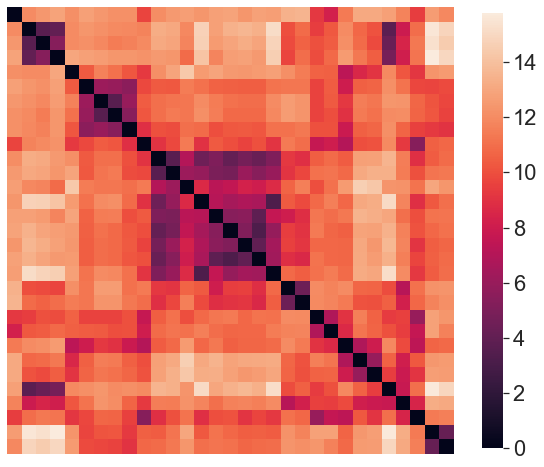

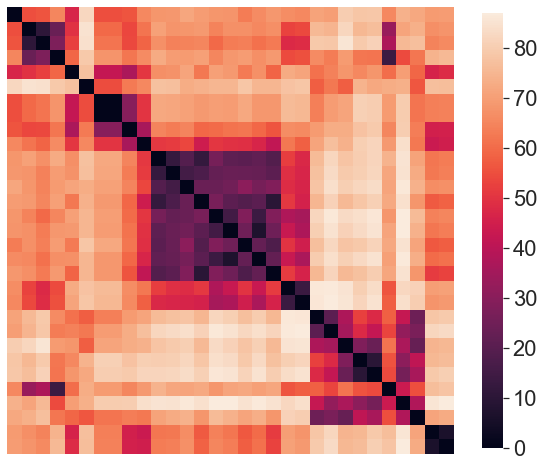

In [3]:
A_order = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]
A_label = ['A*01:01', 'A*26:01', 'A*26:02', 'A*26:03', 'A*29:02', 'A*30:01', 'A*30:02', 'A*30:03', 'A*30:04', 'A*32:01', 'A*02:01', 'A*02:02', 'A*02:03', 'A*02:04', 'A*02:05', 'A*02:06', 'A*02:07', 'A*02:14', 'A*02:17', 'A*68:02', 'A*69:01', 'A*03:01', 'A*11:01', 'A*31:01', 'A*33:01', 'A*33:03', 'A*66:01', 'A*68:01', 'A*74:01', 'A*23:01', 'A*24:02']

AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight, sigma=0.1, w=4)
# AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight)
# heatmap(AMat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)

heatmap(AMat, order=A_order, line=False, shrink=0.8, labelsize=24)
heatmap(BA_Mat, order=A_order, line=False, shrink=0.8, labelsize=24)

In [8]:
# Sidney
A_Sidney = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]

# Doytchinova
A_Doytchinova = [
    ['A01_01','A29_02','A30_01','A30_02','A30_03','A30_04','A32_01','A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01'],
    ['A26_01','A26_02','A26_03','A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01'],
    ['A23_01','A24_02']
]
# elbow_plot(Mat, BA_Mat)
ASidney_SSE = SSE(BA_Mat, A_Sidney)
ADoytchinova_SSE = SSE(BA_Mat, A_Doytchinova)

ASidney_Silhouette = Silhouette(BA_Mat, A_Sidney)
ADoytchinov_Silhouette = Silhouette(BA_Mat, A_Doytchinova)

ASSE_struct, ASSE_BA, ASilhouette_struct, ASilhouette_struct_BA = Tuning_N(AMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)

# elbow_plot(AMat, BA_Mat, [(len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")])
print(f"Sidney SSE:{ASidney_SSE}, Silhouette_coefficient:{ASidney_Silhouette}\nDoytchinova SSE:{ADoytchinova_SSE}, Silhouette_coefficient:{ADoytchinov_Silhouette}")
# elbow_plot(Mat, BA_Mat)

N=1  SE: 158.38211348504646 / BE: 926.3061583577713 / SS: 0 / BS: 0
N=2  SE: 136.79369862587163 / BE: 819.250785123967 / SS: 0.19339224710557704 / BS: 0.1603441079841287
N=3  SE: 117.01231873986998 / BE: 660.5829201101928 / SS: 0.23017917582727762 / BS: 0.24402791078917713
N=4  SE: 105.6570517817215 / BE: 558.6419834710744 / SS: 0.24218406369371678 / BS: 0.2843567201619244
N=5  SE: 93.08740722076581 / BE: 501.59939393939396 / SS: 0.29525637405742244 / BS: 0.29354357830624067
N=6  SE: 82.974037782641 / BE: 447.25545454545454 / SS: 0.3316991836314902 / BS: 0.3190409658711361
N=7  SE: 74.145926330149 / BE: 385.3751515151514 / SS: 0.37043265830692146 / BS: 0.37754777137600587
N=8  SE: 68.75037221696016 / BE: 356.3087878787878 / SS: 0.35711257815680875 / BS: 0.3621984772630415
N=9  SE: 63.51875571101888 / BE: 314.8787878787879 / SS: 0.3508204720524161 / BS: 0.37743202509068313
N=10  SE: 58.72768393476959 / BE: 301.3306818181818 / SS: 0.31761938959957575 / BS: 0.25978003557474905
N=11  SE: 5

### HLA-B

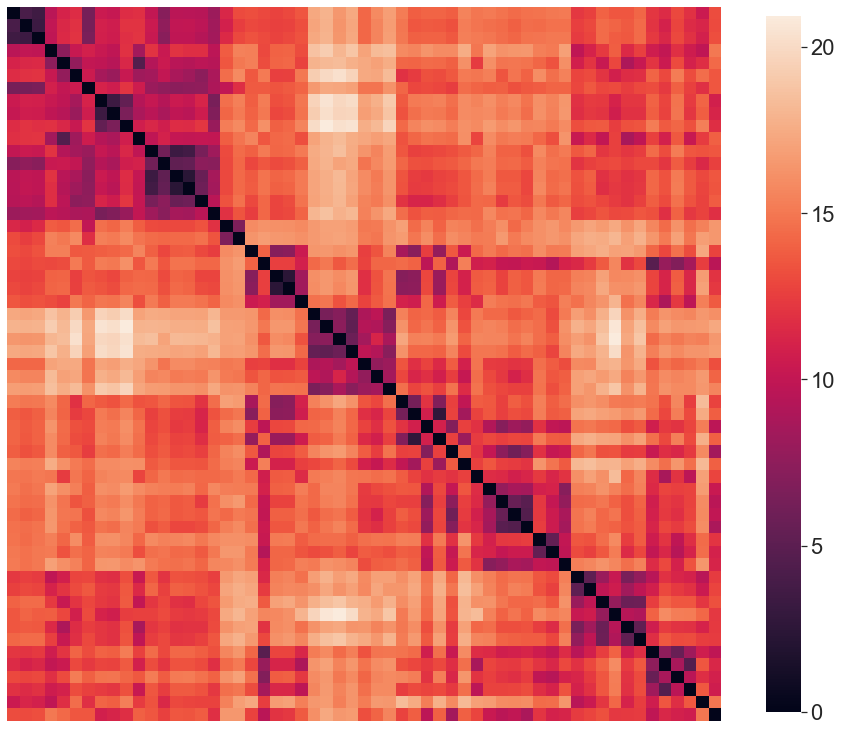

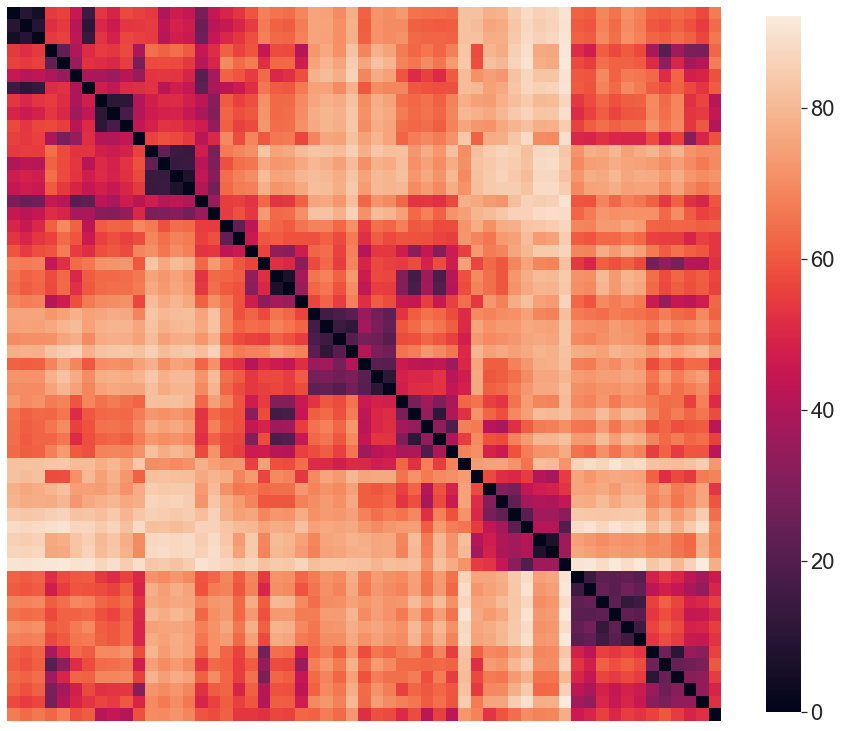

In [7]:
B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
B_label = ['B*07:02','B*07:03','B*07:05','B*15:08','B*35:01','B*35:03','B*42:01','B*51:01','B*51:02','B*51:03','B*53:01','B*54:01','B*55:01','B*55:02','B*56:01','B*67:01','B*78:01','B*08:01','B*08:02','B*14:02','B*15:03','B*15:09','B*15:10','B*15:18','B*27:02','B*27:03','B*27:04','B*27:05','B*27:06','B*27:07','B*27:09','B*38:01','B*39:01','B*39:02','B*39:09','B*48:01','B*73:01','B*18:01','B*37:01','B*40:01','B*40:02','B*40:06','B*44:02','B*44:03','B*45:01','B*15:16','B*15:17','B*57:01','B*57:02','B*58:01','B*58:02','B*15:01','B*15:02','B*15:12','B*15:13','B*46:01','B*52:01']

BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight, sigma=0.1,w=4)
# BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight)
# heatmap(BMat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)

heatmap(BMat, order=B_order, size=(16,16), line=False, shrink=0.8, labelsize=12, ticks=[0, 5, 10, 15, 20])
heatmap(BA_Mat, order=B_order, size=(16,16), line=False, shrink=0.8, labelsize=12)

In [10]:
# Sidney
B_Sidney = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
# Doytchinova
B_Doytchinova = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B14_02','B15_09','B15_10','B15_18','B39_01','B39_09','B73_01','B18_01','B15_02'],
    ['B51_01','B51_02','B51_03','B53_01','B08_02','B27_02','B38_01','B44_02','B44_03','B57_01','B57_02','B58_01','B58_02','B52_01'],
    ['B15_03','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B39_02','B48_01','B37_01','B40_01','B40_02','B40_06','B45_01','B15_16','B15_17','B15_01','B15_12','B15_13','B46_01']
]

BSidney_SSE = SSE(BA_Mat, B_Sidney)
BDoytchinova_SSE = SSE(BA_Mat, B_Doytchinova)

BSidney_Silhouette = Silhouette(BA_Mat, B_Sidney)
BDoytchinov_Silhouette = Silhouette(BA_Mat, B_Doytchinova)

BSSE_struct, BSSE_BA, BSilhouette_struct, BSilhouette_struct_BA = Tuning_N(BMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)
# elbow_plot(BMat, BA_Mat, [(len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")])
print(f"Sidney SSE:{BSidney_SSE}, Silhouette_coefficient:{BSidney_Silhouette}\nDoytchinova SSE:{BDoytchinova_SSE}, Silhouette_coefficient:{BDoytchinov_Silhouette}")

N=1  SE: 377.71772931577465 / BE: 1771.7253588516746 / SS: 0 / BS: 0
N=2  SE: 326.63859925501805 / BE: 1526.2387396694216 / SS: 0.20284518282169467 / BS: 0.20673514342077423
N=3  SE: 300.7745324756433 / BE: 1411.8884956709958 / SS: 0.20780499323693222 / BS: 0.18989539002873776
N=4  SE: 285.2619851789693 / BE: 1354.446287878788 / SS: 0.2246165054079456 / BS: 0.15812679236005722
N=5  SE: 258.2423832535727 / BE: 1232.2535606060605 / SS: 0.25678689664790083 / BS: 0.19331778880762043
N=6  SE: 237.70737985588855 / BE: 1079.4236363636364 / SS: 0.25916326296549197 / BS: 0.24617882421907003
N=7  SE: 228.73046342786537 / BE: 1028.6225000000002 / SS: 0.24918088953661174 / BS: 0.21068498567278482
N=8  SE: 217.74547715801637 / BE: 973.9840584415585 / SS: 0.23658782559968464 / BS: 0.20830132333484866
N=9  SE: 203.49139380015131 / BE: 868.0070887445889 / SS: 0.24387008905457414 / BS: 0.248667789081134
N=10  SE: 194.4751236170121 / BE: 827.3810281385282 / SS: 0.24350946267632922 / BS: 0.21851905426226

### HLA-C

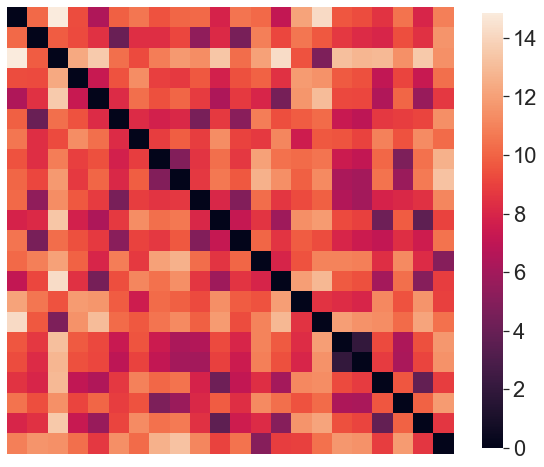

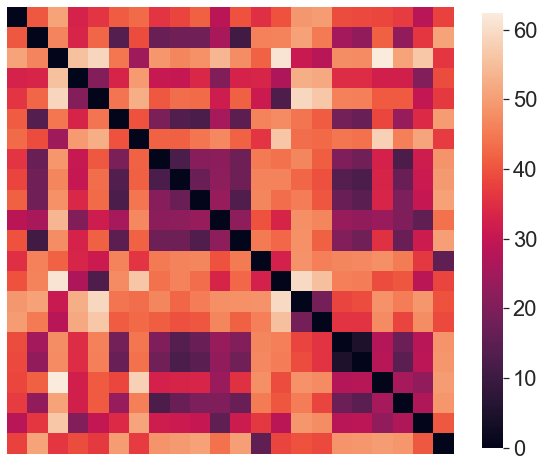

In [5]:
C_order = [
    ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
C_label = ['C*01:02','C*03:02','C*07:02','C*08:01','C*08:02','C*12:02','C*14:02','C*16:01','C*16:04','C*02:02','C*03:07','C*03:15','C*04:01','C*05:01','C*06:02','C*07:07','C*12:04','C*12:05','C*15:02','C*16:02','C*17:01','C*18:01']

CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight, sigma=0.1, w=4)
# CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight)
# heatmap(CMat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)

heatmap(CMat, order=C_order, line=False, shrink=0.8, labelsize=12)
heatmap(BA_Mat, order=C_order, line=False, shrink=0.8, labelsize=12)

In [12]:
# Doytchinova
C_Doytchinova = [
    ['C01_02','C03_02','C07_02','C08_01','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
CDoytchinova_SSE = SSE(BA_Mat, C_Doytchinova)

CDoytchinov_Silhouette = Silhouette(BA_Mat, C_Doytchinova)

CSSE_struct, CSSE_BA, CSilhouette_struct, CSilhouette_struct_BA = Tuning_N(CMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)
# elbow_plot(CMat, BA_Mat, [(len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova")])
print(f"Doytchinova SSE:{CDoytchinova_SSE}, Silhouette_coefficient:{CDoytchinov_Silhouette}")

N=1  SE: 97.33315229359128 / BE: 381.9780991735537 / SS: 0 / BS: 0
N=2  SE: 80.49936797979363 / BE: 310.7339549339549 / SS: 0.2246939632786977 / BS: 0.25503716984794655
N=3  SE: 69.5630924044811 / BE: 243.34570707070702 / SS: 0.241021731442519 / BS: 0.31654434574178064
N=4  SE: 61.79773486462066 / BE: 208.22918470418472 / SS: 0.26228211497959236 / BS: 0.3370025414632074
N=5  SE: 52.74118126160068 / BE: 190.40474025974027 / SS: 0.2854352638483471 / BS: 0.21462784936035503
N=6  SE: 46.58439934264515 / BE: 179.07974025974028 / SS: 0.31916836361858925 / BS: 0.15312891594901462
N=7  SE: 41.96764393190641 / BE: 159.39878787878786 / SS: 0.3001319275482672 / BS: 0.15806349289066704
N=8  SE: 37.38803564339961 / BE: 148.53636363636366 / SS: 0.29646072087714864 / BS: 0.09249442671962438
N=9  SE: 33.63576862966328 / BE: 126.90454545454546 / SS: 0.2809604451329339 / BS: 0.0979546990936103
N=10  SE: 28.3807136513092 / BE: 114.62545454545456 / SS: 0.29748800281347737 / BS: 0.10785300090236373
N=11  S

In [13]:
# random clustering as baseline
import random
import numpy as np

A_ref_alleles = ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01',
'A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01',
'A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01',
'A23_01', 'A24_02']
B_ref_alleles = ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01',
'B08_01','B08_02',
'B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01',
'B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01',
'B15_16','B15_17','B57_01','B57_02','B58_01','B58_02',
'B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
C_ref_alleles = ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04',
'C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
ALL_REF = [A_ref_alleles, B_ref_alleles, C_ref_alleles]

RAND_BA_SSE = []
RAND_BA_Silhouette = []
for ref_alleles in ALL_REF:
    mean_sse = []
    std_sse = []
    mean_silhouette = []
    std_silhouette = []

    for i in range(1, 13):
        n_cluster_sse = []
        n_cluster_silhouette = []
        for _ in range(5):
            random.shuffle(ref_alleles)
            rand_split = np.array_split(ref_alleles, i)
            # print(len(rand_split), ref_alleles)
            # breakpoint()
            n_cluster_sse.append(SSE(BA_Mat, rand_split))
            n_cluster_silhouette.append(Silhouette(BA_Mat, rand_split))
        mean_sse.append(np.mean(n_cluster_sse))
        std_sse.append(np.std(n_cluster_sse))

        mean_silhouette.append(np.mean(n_cluster_silhouette))
        std_silhouette.append(np.std(n_cluster_silhouette))

    RAND_BA_SSE.append((mean_sse, std_sse))
    RAND_BA_Silhouette.append((mean_silhouette, std_silhouette))


In [15]:
RAND_BA_Silhouette

[([0.0,
   -0.00929066156278984,
   -0.053575706482252836,
   -0.08447933114114722,
   -0.11695291132339025,
   -0.1481283646570614,
   -0.16253046370065832,
   -0.2044799726574821,
   -0.23990814927203039,
   -0.24674756052525532,
   -0.2771620594473941,
   -0.3070062134242624],
  [0.0,
   0.008183536194140388,
   0.004082164235246889,
   0.004145915363093635,
   0.005904579461498788,
   0.017287629646395675,
   0.025961313645949443,
   0.023031203584783656,
   0.015583351321670763,
   0.035768581554850395,
   0.010487967587853768,
   0.017238051102573922]),
 ([0.0,
   0.006013585734524187,
   -0.029674406080154803,
   -0.05184348391237013,
   -0.0756183028473078,
   -0.0948401694026993,
   -0.09480663442111029,
   -0.1299799486451097,
   -0.14917955530698684,
   -0.15381309632121976,
   -0.17157083518206415,
   -0.18753549713053258],
  [0.0,
   0.012357250008212816,
   0.013736140781852141,
   0.00750054733667863,
   0.007297316504693065,
   0.0053428063142729925,
   0.01953271582959

### combine all three subplots

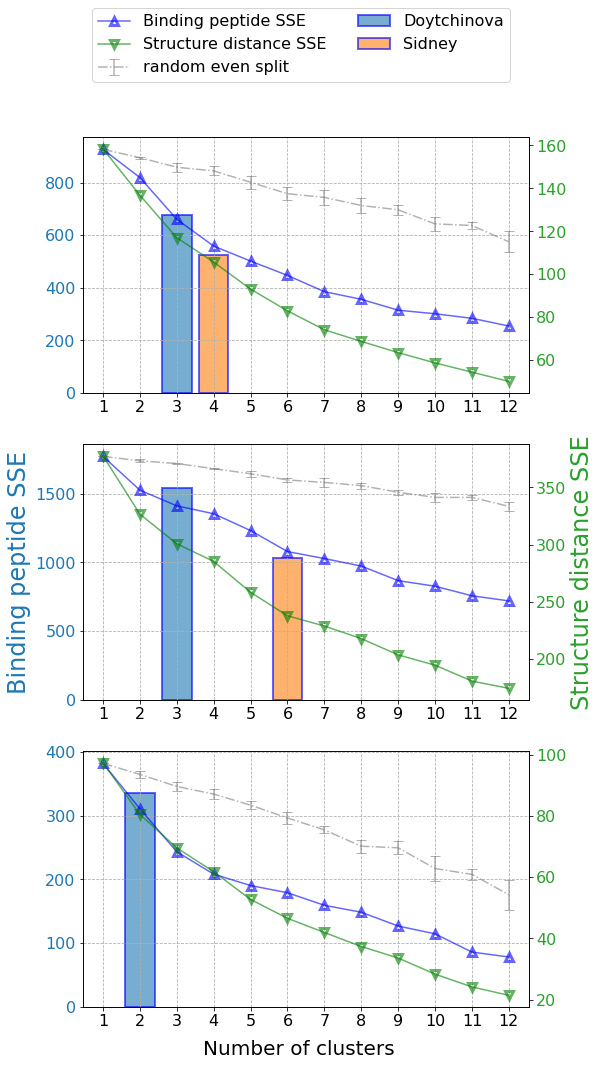

In [10]:
SSE_BA_list = [ASSE_BA, BSSE_BA, CSSE_BA]
SSE_struct_list = [ASSE_struct, BSSE_struct, CSSE_struct]
SSE_other = [((len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")), ((len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")), ((len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova"),)]

xx = range(1, 13)

fig, axes = plt.subplots(3, 1, figsize=(8,16))
i=1
for ax1, SSE_BA, SSE_struct, SSE_random, Additional_Bar_group in zip(axes, SSE_BA_list, SSE_struct_list, RAND_BA_SSE, SSE_other):

    # lines = []
    # labels = []
    ax2 = ax1.twinx()

    # line plots
    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="Binding peptide SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure distance SSE")
    # lines.append(line1)
    # labels.append("Binding peptide SSE")
    # lines.append(line2)
    # labels.append("Structure distance SSE")

    # random splits
    randoms = ax1.errorbar(xx, SSE_random[0], yerr=SSE_random[1], alpha=0.6, ls='-.', capsize=5, color='gray', label="random even split")
    # lines.append(randoms)
    # labels.append("random even split SSE")

    # ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,13,1))
    ax1.tick_params(axis='x', labelsize=16)

    if i == 2:
        lines = []
        labels = []
        lines.append(line1)
        labels.append("Binding peptide SSE")
        lines.append(line2)
        labels.append("Structure distance SSE")
        lines.append(randoms)
        labels.append("random even split")

        ax1.set_ylabel('Binding peptide SSE', color='tab:blue', fontsize=24)
        ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
    

    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    # bar plots
    for group in Additional_Bar_group:
        # print(group)
        # lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
        # labels.append(f"{group[2]} (n={group[0]})")
        bar = ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b')

        if i == 2:
            lines.append(bar)
            labels.append(group[2])

    # ax1.legend(lines, labels, prop={"size":16}, loc=1)
    ax1.grid(linestyle='--')
    i += 1

fig.legend(lines, labels, prop={"size":16}, loc=9, ncol=2)
fig.supxlabel("Number of clusters", fontsize=20, y=0.08)

plt.show()

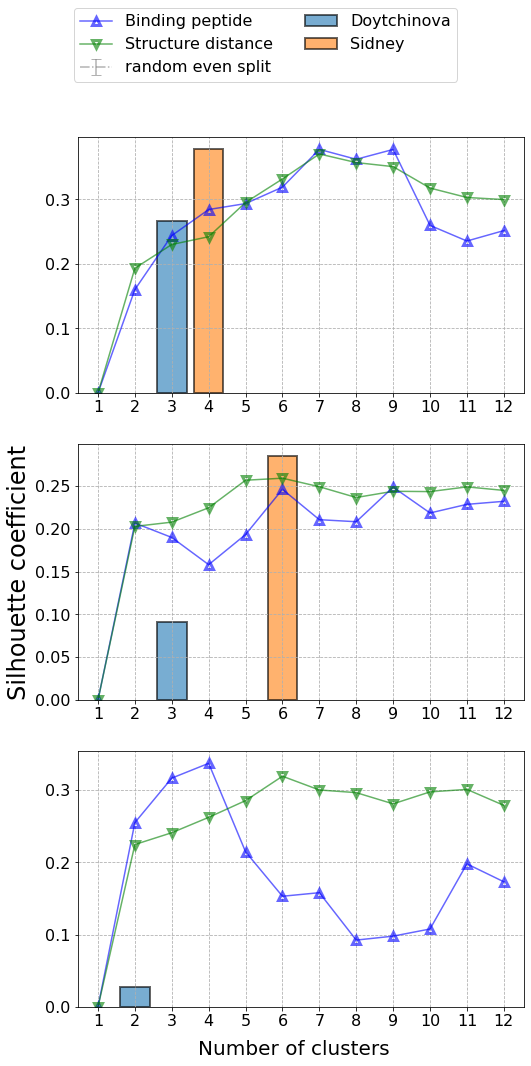

In [25]:
Silhouette_BA_list = [ASilhouette_struct_BA, BSilhouette_struct_BA, CSilhouette_struct_BA]
Silhouette_struct_list = [ASilhouette_struct, BSilhouette_struct, CSilhouette_struct]
Silhouette_other = [((len(A_Doytchinova),ADoytchinov_Silhouette, "Doytchinova"), (len(A_Sidney),ASidney_Silhouette, "Sidney")),
                    ((len(B_Doytchinova),BDoytchinov_Silhouette, "Doytchinova"), (len(B_Sidney),BSidney_Silhouette, "Sidney")),
                    ((len(C_Doytchinova),CDoytchinov_Silhouette, "Doytchinova"),)]

xx = range(1, 13)

fig, axes = plt.subplots(3, 1, figsize=(8,16))
i=1
for ax1, SSE_BA, SSE_struct, SSE_random, Additional_Bar_group in zip(axes, Silhouette_BA_list, Silhouette_struct_list, RAND_BA_Silhouette, Silhouette_other):

    # lines = []
    # labels = []
    # ax2 = ax1.twinx()

    # line plots
    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="Binding peptide")
    line2, = ax1.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure distance")
    # lines.append(line1)
    # labels.append("Binding peptide SSE")
    # lines.append(line2)
    # labels.append("Structure distance SSE")

    # random splits
    # randoms = ax1.errorbar(xx, SSE_random[0], yerr=SSE_random[1], alpha=0.6, ls='-.', capsize=5, color='gray', label="random even split")
    # lines.append(randoms)
    # labels.append("random even split SSE")

    # ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,13,1))
    ax1.tick_params(axis='x', labelsize=16)

    if i == 2:
        lines = []
        labels = []
        lines.append(line1)
        labels.append("Binding peptide")
        lines.append(line2)
        labels.append("Structure distance")
        lines.append(randoms)
        labels.append("random even split")

        ax1.set_ylabel('Silhouette coefficient', fontsize=24)
        # ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
    

    ax1.tick_params(axis='y', labelsize=16)
    # ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    # bar plots
    for group in Additional_Bar_group:
        # print(group)
        # lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
        # labels.append(f"{group[2]} (n={group[0]})")
        bar = ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='k')

        if i == 2:
            lines.append(bar)
            labels.append(group[2])

    # ax1.legend(lines, labels, prop={"size":16}, loc=1)
    ax1.grid(linestyle='--')
    i += 1

fig.legend(lines, labels, prop={"size":16}, loc=9, ncol=2)
fig.supxlabel("Number of clusters", fontsize=20, y=0.08)

plt.show()

### All Binding Affinity data

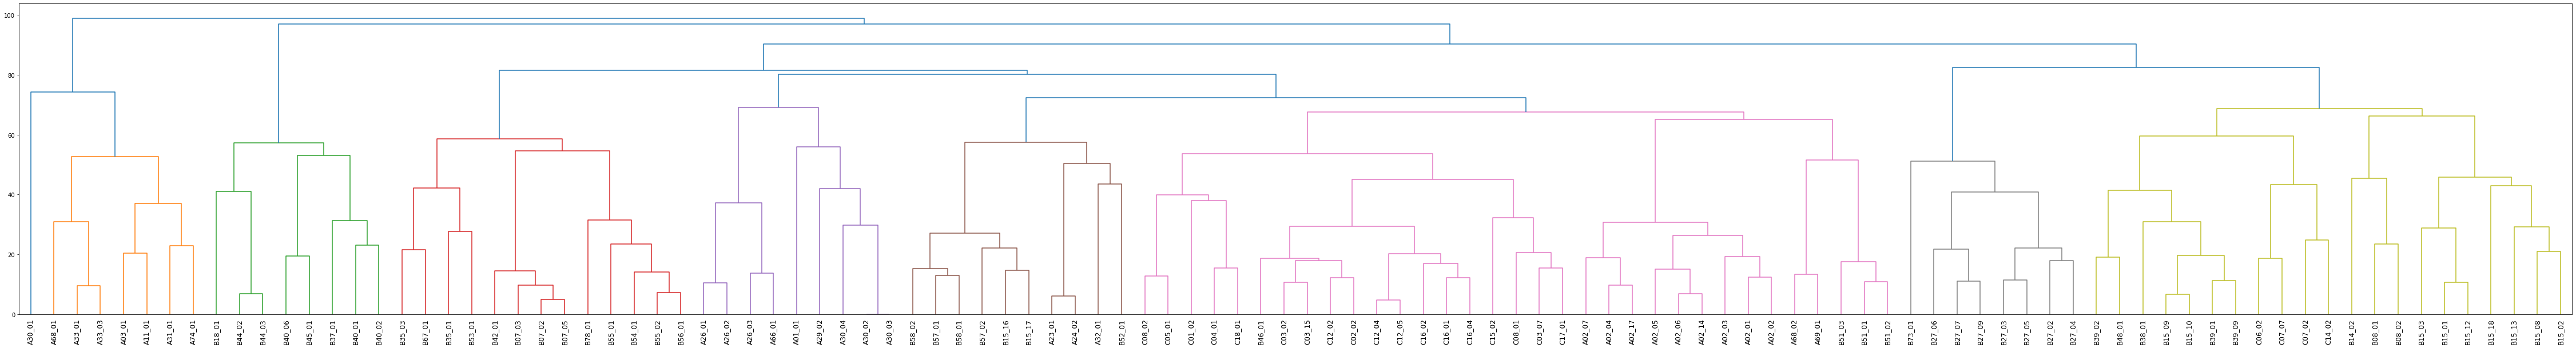

In [26]:
cluster, order = hierarchical_cluster(BA_Mat, N=12, plot_dendro=True)

N=3  SE: 3034.9831721470014 / BE: NA / SS: 0.2627922299766596 / BS: NA
N=4  SE: 2802.7830793344583 / BE: NA / SS: 0.18933111577418282 / BS: NA
N=5  SE: 2662.628024475525 / BE: NA / SS: 0.17761776839855384 / BS: NA
N=6  SE: 2459.3729895104893 / BE: NA / SS: 0.21635940370575593 / BS: NA
N=7  SE: 2331.1291639561987 / BE: NA / SS: 0.23218985005634699 / BS: NA
N=8  SE: 2287.0213717484066 / BE: NA / SS: 0.22913962113913858 / BS: NA
N=9  SE: 2172.2520822359456 / BE: NA / SS: 0.23078683622935137 / BS: NA
N=10  SE: 2092.7196579935217 / BE: NA / SS: 0.2455435218230347 / BS: NA
N=11  SE: 2009.291641464596 / BE: NA / SS: 0.25010427872010815 / BS: NA
N=12  SE: 1830.8307661357783 / BE: NA / SS: 0.2915406262127257 / BS: NA
N=13  SE: 1762.2986882137006 / BE: NA / SS: 0.29614604768583563 / BS: NA
N=14  SE: 1660.6133202483327 / BE: NA / SS: 0.3171166681188088 / BS: NA
N=15  SE: 1583.8250380759594 / BE: NA / SS: 0.3312449330606426 / BS: NA
N=16  SE: 1527.8676177185391 / BE: NA / SS: 0.33568472543726846 /

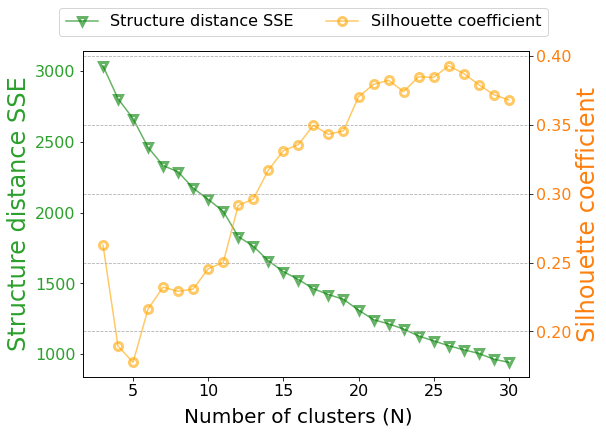

In [74]:
# groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
# Silhouette(BA_Mat, groups)
ALL_SSE, _, ALL_Silhouette, _ = Tuning_N(BA_Mat, None, 3, 30, StructSilhouette=True)
xx = range(3, 31)

fig, ax1 = plt.subplots(figsize=(8,6))

# ax1 = axes[0]
ax2 = ax1.twinx()

line1, = ax1.plot(xx, ALL_SSE, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure distance SSE")
line2, = ax2.plot(xx, ALL_Silhouette, c='orange', marker='o', mfc='None', mec='orange', ms=8, mew=3, alpha=0.6, label="Silhouette coefficient")

ax1.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
ax2.set_ylabel('Silhouette coefficient', color='tab:orange', fontsize=24)
# plt.legend()
# plt.tick_params('x', labelsize=16)
# plt.tick_params('y', labelsize=16)

ax1.tick_params(axis='y', labelcolor='tab:green', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)

fig.supxlabel('Number of clusters (N)', fontsize=20)
# plt.ylabel('Structure Distance SSE', fontsize=20)
# plt.axvline(x=6, c='k', linestyle=':')
# plt.annotate('N=6', xy=(0.16, 0.05), xycoords='axes fraction', fontsize=16)
# plt.axvline(x=12, c='k', linestyle=':')
# plt.annotate('N=12', xy=(0.36, 0.05), xycoords='axes fraction', fontsize=16)
plt.grid(linestyle='--')

fig.legend([line1, line2], ["Structure distance SSE", "Silhouette coefficient"], prop={"size":16}, loc=9, ncol=2)

plt.show()

### All HLA I alleles

In [42]:
# Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight, sigma=0.1, w=4)
Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight)
# print(Mat)
# heatmap(Mat, order=None, line=False, size=(80,80), shrink=0.8, aspect=40, pad=0.02)
# Matrix2Dendro(Mat, "HLA-I_cg.newick")
Mat.to_csv("HLA-I_cg_dist_old.csv")

N=3  SE: 3075.0581802521688 / BE: NA / SS: 0.13608803839620953 / BS: NA
N=4  SE: 3047.9973617365467 / BE: NA / SS: 0.13405066156963893 / BS: NA
N=5  SE: 2826.782172694171 / BE: NA / SS: 0.17998667018818035 / BS: NA
N=6  SE: 2722.614635365837 / BE: NA / SS: 0.2001961468412407 / BS: NA
N=7  SE: 2669.2276048083004 / BE: NA / SS: 0.19187892197232662 / BS: NA
N=8  SE: 2622.76066540132 / BE: NA / SS: 0.18247496117171913 / BS: NA
N=9  SE: 2552.7185122398723 / BE: NA / SS: 0.18008569276924927 / BS: NA
N=10  SE: 2511.714325018094 / BE: NA / SS: 0.18809943374822227 / BS: NA
N=11  SE: 2475.935044607814 / BE: NA / SS: 0.1905183909634952 / BS: NA
N=12  SE: 2422.350174140733 / BE: NA / SS: 0.19866773155493098 / BS: NA
N=13  SE: 2382.078728331769 / BE: NA / SS: 0.19193917094791052 / BS: NA
N=14  SE: 2367.470417212851 / BE: NA / SS: 0.1838069885202615 / BS: NA
N=15  SE: 2352.22867995589 / BE: NA / SS: 0.17230715616054562 / BS: NA
N=16  SE: 2313.4486474517334 / BE: NA / SS: 0.17071768468489912 / BS: NA

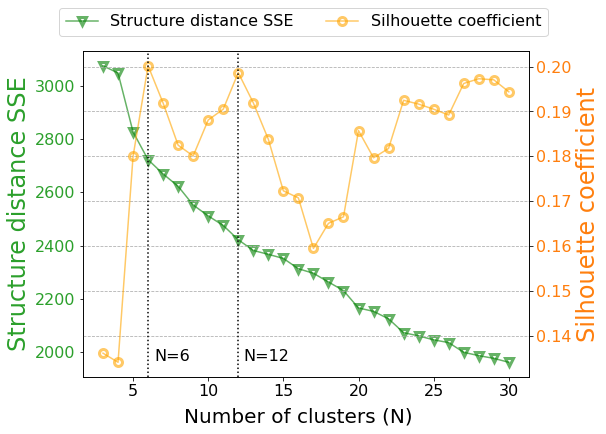

In [70]:
# Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
Mat = pd.read_csv("HLA-I_cg_dist_old.csv", index_col=0)

SSE_struct, _, SilhouetteScore, _ = Tuning_N(Mat, None, 3, 30, StructSilhouette=True)
xx = range(3, 31)

fig, ax1 = plt.subplots(figsize=(8,6))

# ax1 = axes[0]
ax2 = ax1.twinx()

line1, = ax1.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure distance SSE")
line2, = ax2.plot(xx, SilhouetteScore, c='orange', marker='o', mfc='None', mec='orange', ms=8, mew=3, alpha=0.6, label="Silhouette coefficient")

ax1.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
ax2.set_ylabel('Silhouette coefficient', color='tab:orange', fontsize=24)
# plt.legend()
# plt.tick_params('x', labelsize=16)
# plt.tick_params('y', labelsize=16)

ax1.tick_params(axis='y', labelcolor='tab:green', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)

fig.supxlabel('Number of clusters (N)', fontsize=20)
# plt.ylabel('Structure Distance SSE', fontsize=20)
plt.axvline(x=6, c='k', linestyle=':')
plt.annotate('N=6', xy=(0.16, 0.05), xycoords='axes fraction', fontsize=16)
plt.axvline(x=12, c='k', linestyle=':')
plt.annotate('N=12', xy=(0.36, 0.05), xycoords='axes fraction', fontsize=16)
plt.grid(linestyle='--')

fig.legend([line1, line2], ["Structure distance SSE", "Silhouette coefficient"], prop={"size":16}, loc=9, ncol=2)

plt.show()

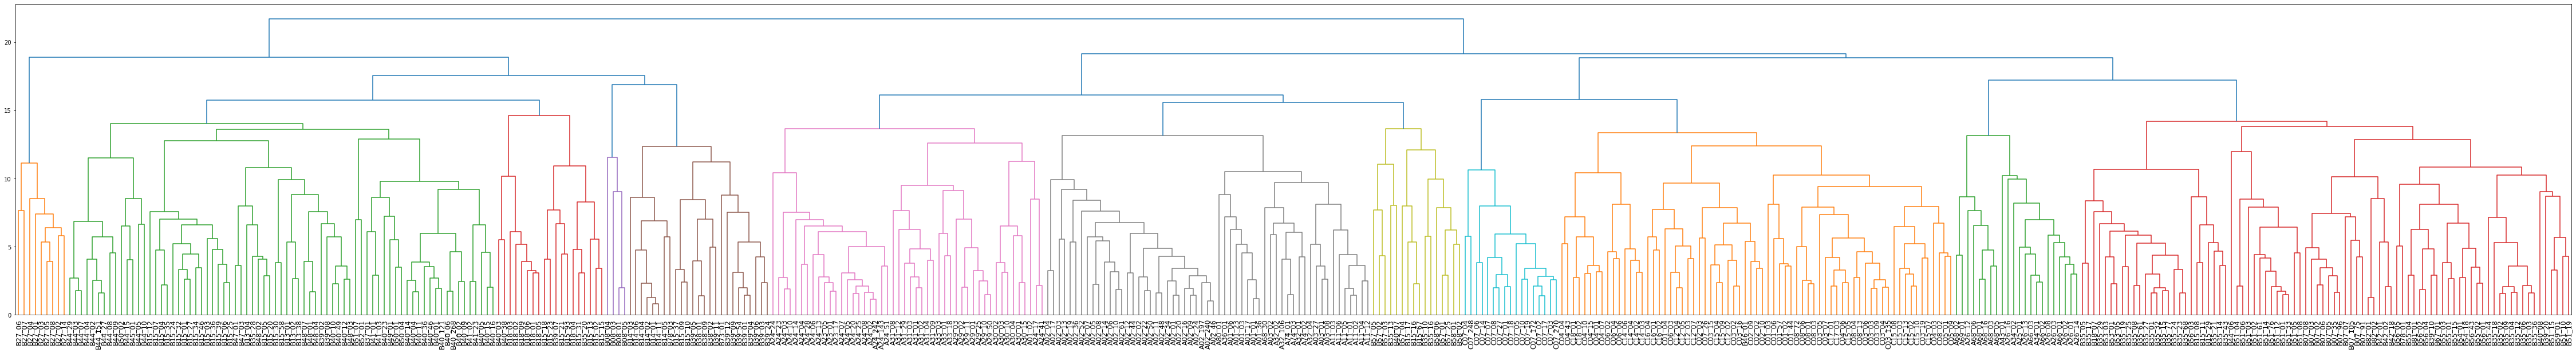

[['B27_06', 'B27_07', 'B27_04', 'B27_01', 'B27_03', 'B27_05', 'B27_08', 'B27_02', 'B27_14'], ['B44_29', 'B44_03', 'B44_07', 'B44_04', 'B44_02', 'B44_151', 'B44_27', 'B44_08', 'B44_09', 'B50_02', 'B44_15', 'B45_01', 'B44_05', 'B44_10', 'B15_12', 'B15_07', 'B15_04', 'B15_35', 'B15_24', 'B15_32', 'B15_01', 'B15_27', 'B15_34', 'B15_46', 'B15_03', 'B15_36', 'B15_39', 'B15_06', 'B15_25', 'B47_01', 'B47_03', 'B13_04', 'B35_28', 'B48_02', 'B15_05', 'B15_20', 'B15_30', 'B15_58', 'B13_01', 'B13_02', 'B13_38', 'B48_07', 'B48_01', 'B48_04', 'B39_02', 'B39_08', 'B40_10', 'B40_49', 'B40_12', 'B48_03', 'B51_07', 'B52_01', 'B37_01', 'B41_01', 'B41_03', 'B40_23', 'B49_01', 'B50_01', 'B50_04', 'B40_14', 'B40_04', 'B40_11', 'B40_36', 'B40_46', 'B40_01', 'B40_121', 'B40_06', 'B40_268', 'B40_02', 'B40_09', 'B41_02', 'B41_23', 'B40_05', 'B40_15', 'B40_16'], ['B40_03', 'B40_38', 'B18_03', 'B18_02', 'B18_09', 'B18_06', 'B18_01', 'B18_05', 'B15_18', 'B15_23', 'B39_07', 'B15_21', 'B15_93', 'B18_04', 'B15_31', '

In [75]:
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
cluster, order = hierarchical_cluster(Mat, N=12, L='complete', color_threshold=None, plot_dendro=True, outtree="Fig4-24.newick")

name_order = Mat.index[order].to_list()
group_dict = cluster.to_dict()

full_CG_order = []
temp_group = None
last_group = -1
for name in name_order:
    if group_dict[name] != last_group:
        temp_group = []
        full_CG_order.append(temp_group)

    temp_group.append(name)
    last_group = group_dict[name]

print(full_CG_order)

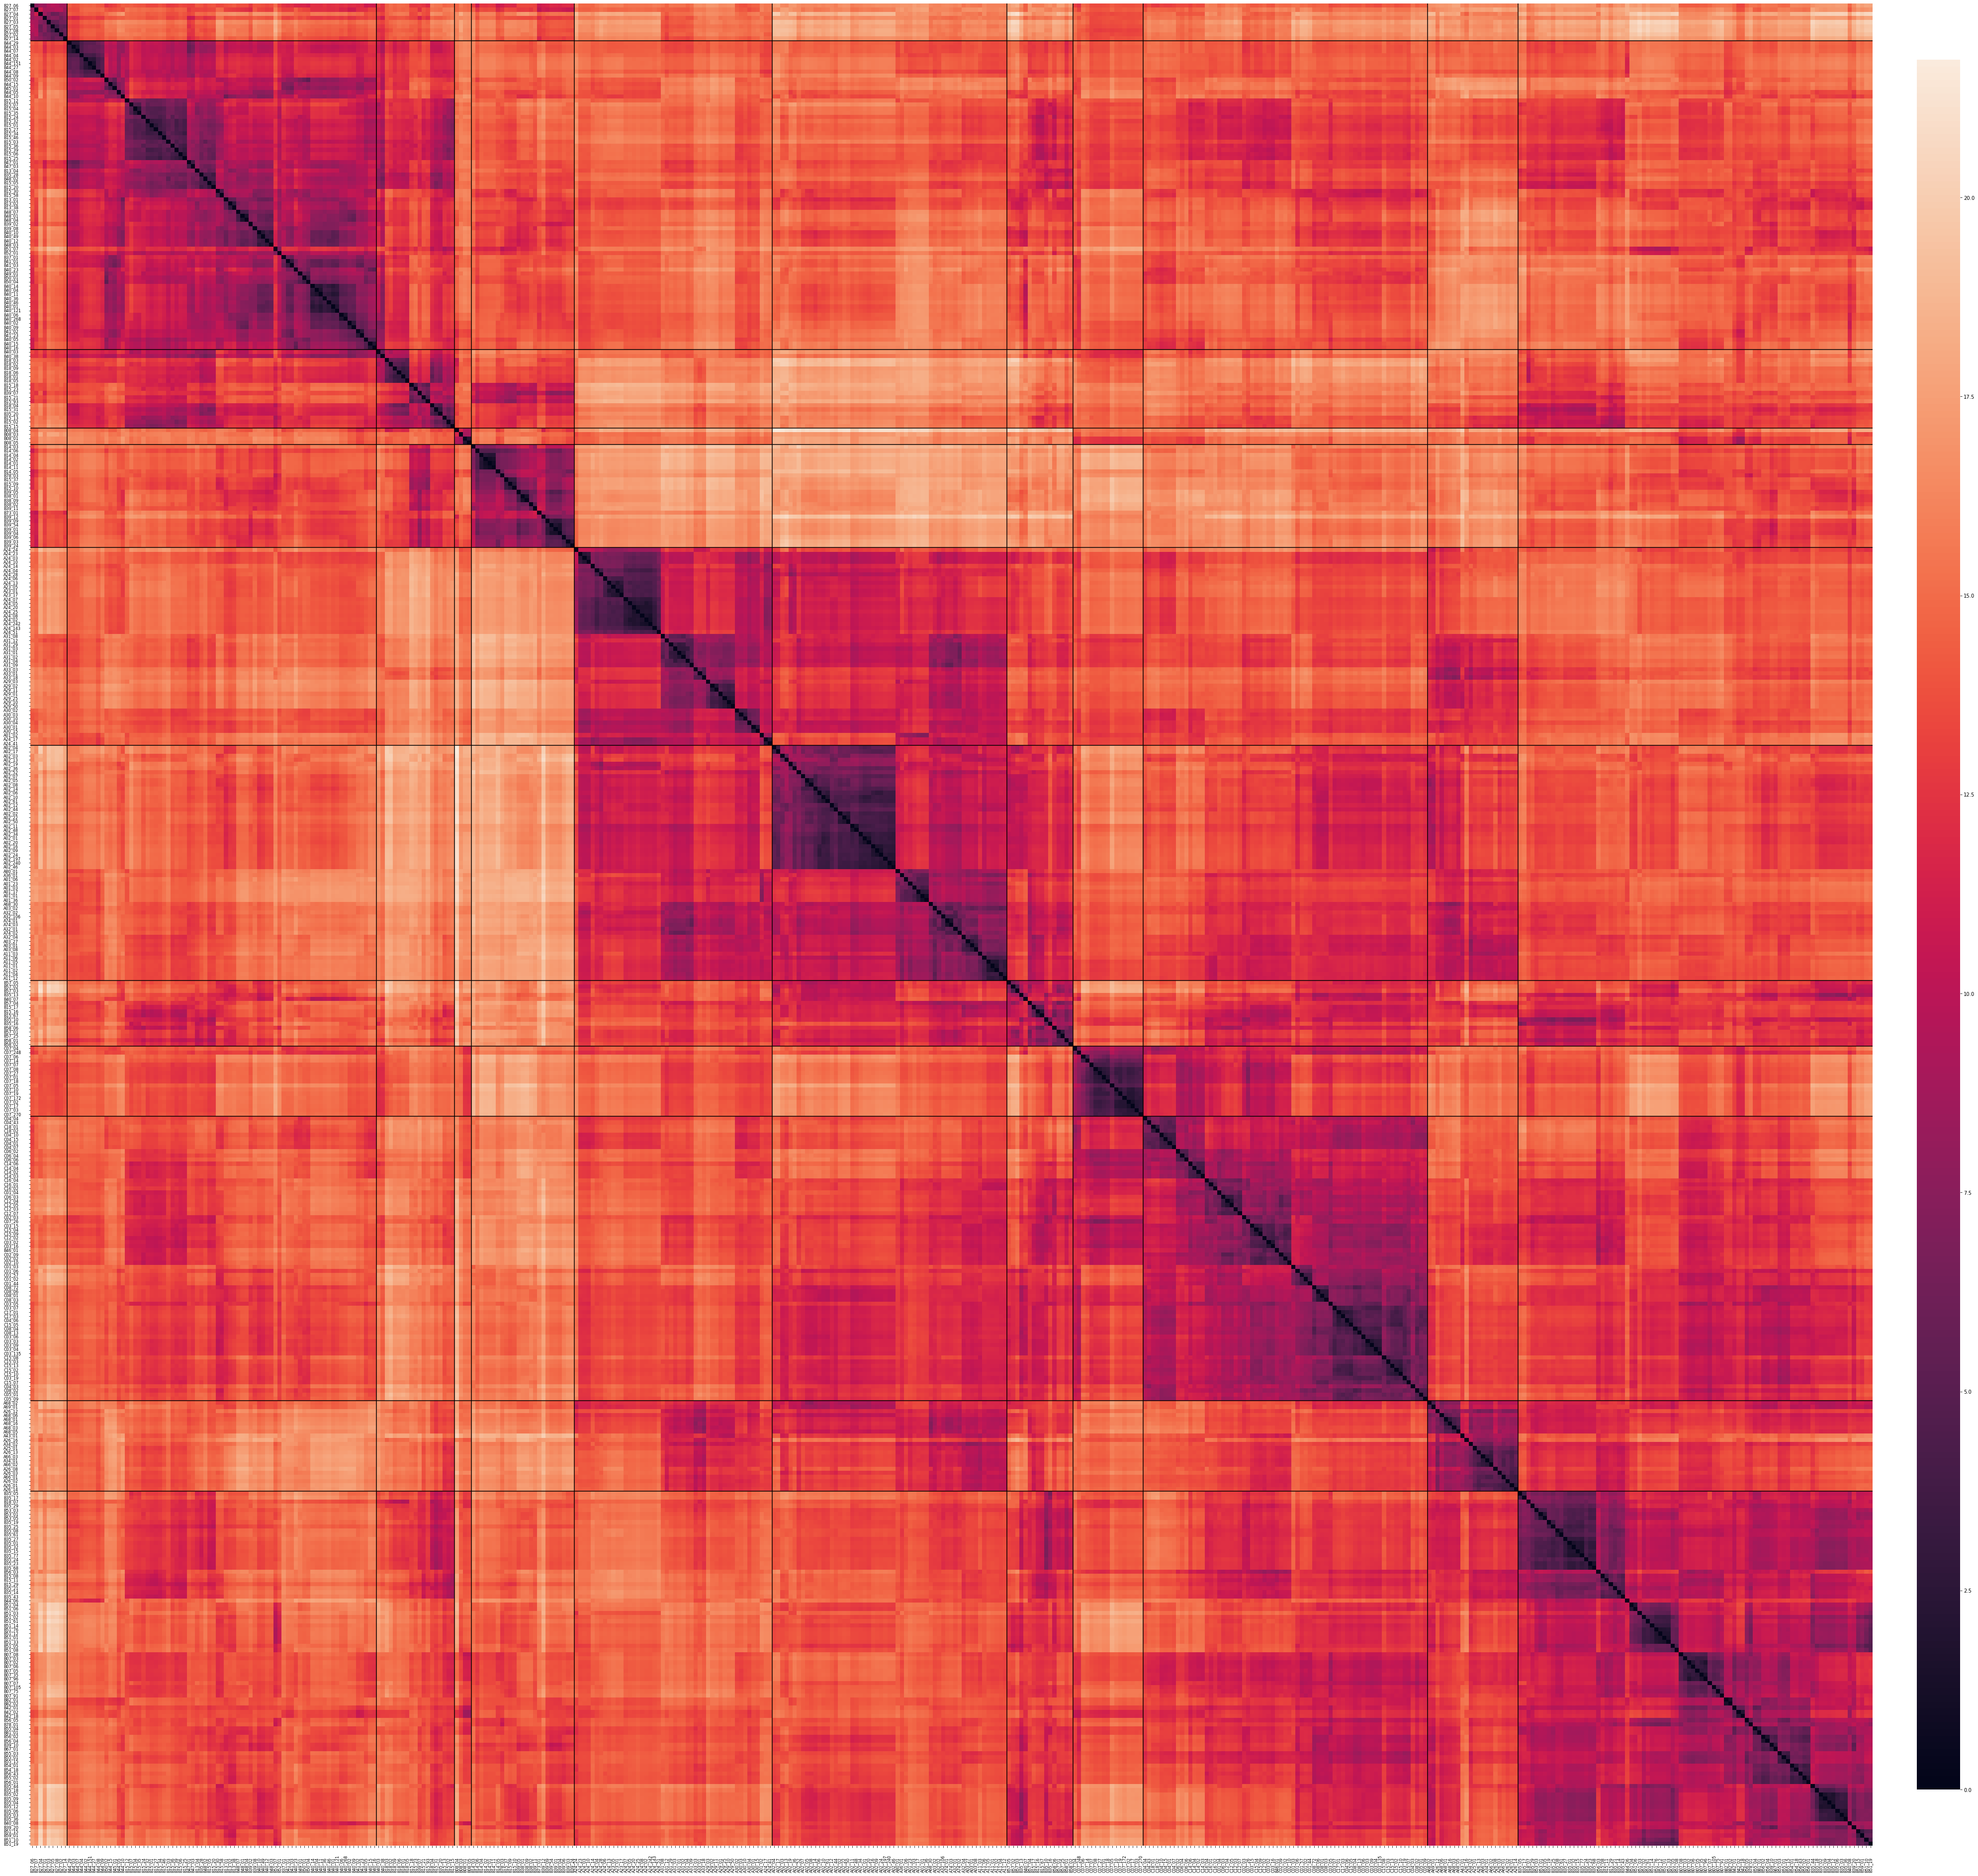

In [76]:
heatmap(Mat, order=full_CG_order, size=(80,80), line=True, shrink=0.8, aspect=40, pad=0.02)

In [24]:
print(cluster.to_string())

A01_01      5
A01_02      3
A01_03      5
A01_06      5
A01_17      5
A01_23      5
A01_36      5
A02_01      5
A02_02      5
A02_03      5
A02_04      5
A02_05      5
A02_06      5
A02_07      5
A02_08      5
A02_09      5
A02_10      5
A02_11      5
A02_12      5
A02_13      5
A02_14      5
A02_16      5
A02_17      5
A02_19      5
A02_197     5
A02_20      5
A02_22      5
A02_24      5
A02_240     5
A02_34      5
A02_36      5
A02_44      5
A02_46      5
A02_48      5
A02_50      5
A02_52      5
A02_61      5
A03_01      5
A03_02      5
A03_08      5
A03_27      5
A11_01      5
A11_02      5
A11_03      5
A11_04      5
A11_05      5
A11_06      5
A11_12      5
A23_01      3
A23_05      3
A23_17      3
A24_02      3
A24_03      3
A24_04      3
A24_05      3
A24_06      3
A24_07      3
A24_08      3
A24_10      3
A24_13      3
A24_14      3
A24_143     3
A24_17      3
A24_20      3
A24_23      3
A24_24      3
A24_242     3
A24_25      3
A24_28      3
A24_41      3
A24_51      3
A25_01